In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from Bio import Phylo
import re

from ete3 import Tree
from matplotlib.colors import ListedColormap

import phylovelo as pv


/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
data_path = '/data3/wangkun/phylovelo_datasets/embryo/'

In [5]:
count = pd.read_csv(data_path+'embryo6/scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'embryo6/scRNA_metadata.csv', index_col=0)

In [6]:
from ete3 import Tree
from io import StringIO

with open(data_path+'trees/embryo6_all.newick', 'r') as f:
    tree_nwk = f.readline()
t = Tree(tree_nwk)
f = StringIO(t.write())
tree = Phylo.read(f, 'newick')
f.close()
terminals = [i.name for i in tree.get_terminals()]
cell_names = list(set(count.index).intersection(set(terminals)))
count = count.loc[cell_names]

tree_depths = tree.depths()
depths_map = dict()
for i in tree_depths:
    depths_map[i.name] = tree_depths[i]
depths = [depths_map[i] for i in cell_names]

In [7]:
em = 6
alleletab = pd.read_csv(data_path + f'GSM{3302826+em}_embryo{em}_alleleTable.txt', sep='\t', index_col=0) 
mutnum = []
for bc in cell_names:
    sel_alleles = alleletab.loc[f'{bc}-1']
    if len(sel_alleles.shape) == 2:
        sel_alleles = '_'.join(sel_alleles['allele1']).split('_')
    else:
        sel_alleles = sel_alleles['allele1'].split('_')

    mutnum.append(len(sel_alleles)-sel_alleles.count('None'))

In [8]:
import anndata as ad
adata = ad.AnnData(count)
sd = pv.scData(count=pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names))
sc.pp.filter_genes(adata, min_counts=20)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sd.x_normed = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
sd.phylo_tree = tree
sd.drop_duplicate_genes(target='x_normed')
sd.cell_states = sd.cell_states = metadata.loc[sd.count.index]['cluster'].to_numpy()
sd.dimensionality_reduction(target='x_normed', method='umap')

In [35]:
pv.velocity_inference(sd, mutnum, cutoff=0.97, target='x_normed')
pv.velocity_embedding(sd, target='x_normed', n_neigh=800)

  0%|          | 0/14146 [00:00<?, ?it/s]

  0%|          | 0/10224 [00:00<?, ?it/s]

In [9]:
vels_em = pd.read_csv('./megs/embryo6_all_mutnum.csv', index_col=0)
vel = []
for i in sd.x_normed.columns:
    try:
        vel.append(vels_em['velocity'].loc[i])
    except:
        vel.append(0)
sd.velocity = np.array(vel)
cell_state_map = {0:'trophoblast stem cells',1:'neural ectoderm anterior',2:'primitive streak late',3:'anterior primitive streak',4:'primitive\ndefinitive endoderm',5:'allantois',6:'secondary heart field\nsplanchnic lateral plate',7:'gut endoderm',8:'ectoderm early 1',9:'primitive blood early',10:'preplacodalectoderm',11:'neural ectoderm posterior',12:'posterior lateral plate mesoderm',13:'hematopoietic\nendothelial progenitors',14:'parietal endoderm',15:'amnion mesoderm early',16:'surface ectoderm',17:'epiblast',18:'somites',19:'ectoderm early',20:'splanchnic lateral plate\nanterior paraxialmesoderm',21:'primitive heart tube',22:'primitive blood late',23:'notochord',24:'fore/midbrain',25:'distal extraembryonic ectoderm',26:'neuromesodermal progenitor early',27:'primordial germ cells',28:'differentiated trophoblasts',29:'visceral endoderm early',30:'presomitic mesoderm',31:'neuromesodermal progenitor late',32:'angioblasts',33:'neural crest',34:'pharyngeal arch mesoderm',35:'similar to neural crest',36:'primitive blood progenitors',37:'primitive streak early',38:'node',39:'future spinal cord',40:'visceral endoderm late',41:'amnion mesoderm late'}
colors = ['#5D8AA8','#F0F8FF','#E32636','#E52B50','#FFBF00','#A4C639','#8DB600','#FBCEB1','#7FFFD4','#4B5320','#3B444B','#E9D66B','#B2BEB5','#87A96B','#FF9966','#6D351A','#007FFF','#89CFF0','#A1CAF1','#F4C2C2','#FFD12A','#848482','#98777B','#F5F5DC','#3D2B1F','#000000','#318CE7','#FAF0BE','#0000FF','#DE5D83','#79443B','#CC0000','#B5A642','#66FF00','#BF94E4','#C32148','#FF007F','#08E8DE','#D19FE8','#004225','#CD7F32','#964B00','#FFC1CC','#E7FEFF','#F0DC82','#800020','#DEB887','#CC5500']
pv.velocity_embedding(sd, target='x_normed', n_neigh=800)

  0%|          | 0/10224 [00:00<?, ?it/s]

In [24]:
colortable = {
    'allantois':'#492488',
    'amnion mesoderm early':'#b6c9d5',
    'amnion mesoderm late':'#6f899c',
    'angioblasts':'#9f2a85',
    'anterior primitive streak':'#b8a383',
    'differentiated trophoblasts':'#996866',
    'distal extraembryonic ectoderm':'#f2c1ce',
    'ectoderm early':'#e5542c',
    'ectoderm early 1':'#ff6b30',
    'epiblast':'#655849',
    'fore/midbrain':'#647752',
    'future spinal cord':'#e6ffaf',
    'gut endoderm':'#d0729e',
    'hematopoietic\nendothelial progenitors':'#d8af8e',
    'neural crest':'#c3c299',
    'neural ectoderm anterior':'#a4c386',
    'neural ectoderm posterior':'#d6ffaf',
    'neuromesodermal progenitor early':'#94c592',
    'neuromesodermal progenitor late':'#6d926c',
    'node':'#999999',
    'notochord':'#2b458e',
    'parietal endoderm':'#010101',
    'pharyngeal arch mesoderm':'#e0edf8',
    'posterior lateral plate mesoderm':'#d9e6f2',
    'preplacodalectoderm':'#a28897',
    'presomitic mesoderm':'#103045',
    'primitive\ndefinitive endoderm':'#bfbfbf',
    'primitive blood early':'#c13745',
    'primitive blood late':'#e68e83',
    'primitive blood progenitors':'#c5aaa0',
    'primitive heart tube':'#c27927',
    'primitive streak early':'#a29076',
    'primitive streak late':'#d5be9c',
    'primordial germ cells':'#eec8de',
    'secondary heart field\nsplanchnic lateral plate':'#b7c2cc',
    'similar to neural crest':'#e6e9a5',
    'somites':'#325e71',
    'splanchnic lateral plate\nanterior paraxialmesoderm':'#54464e',
    'surface ectoderm':'#f4f5a8',
    'trophoblast stem cells':'#654544',
    'visceral endoderm early':'#efbdca',
    'visceral endoderm late':'#bc949e',
}

Text(0.5, 1.0, 'Embryo6')

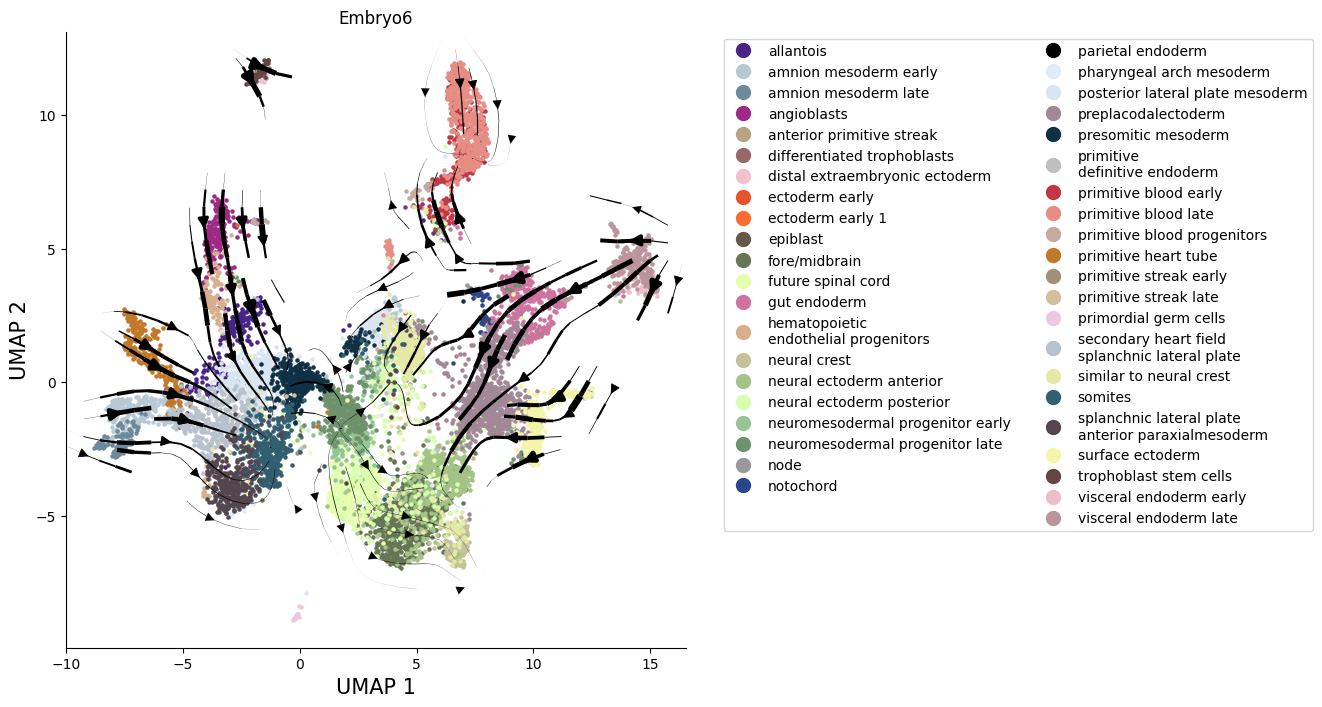

In [30]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(figsize=(8,8))
all_states = np.array(list(set(cell_state_map.keys())))
all_states = all_states[np.argsort(list(cell_state_map.values()))]
lgnds = []
for i in all_states:
    ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c=colortable[cell_state_map[i]], alpha=1, s=5)
    lgnds.append(mlines.Line2D([], [], 
                               color=colortable[cell_state_map[i]],
                               marker='o', markersize=10, lw=0 ,label=cell_state_map[i]
                              ))
pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=50, radius=1, lw_coef=20000, arrowsize=1.5)
lgnd = ax.legend(handles=lgnds, ncol=2, bbox_to_anchor=(1.05, 1.0), loc='upper left')
# for i in lgnd.legendHandles:
#     i._size = 20
# lgnd.legendHandles[0]._alpha = [1]
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Embryo6')

Text(0.5, 1.0, 'Embryo6 - primitive blood')

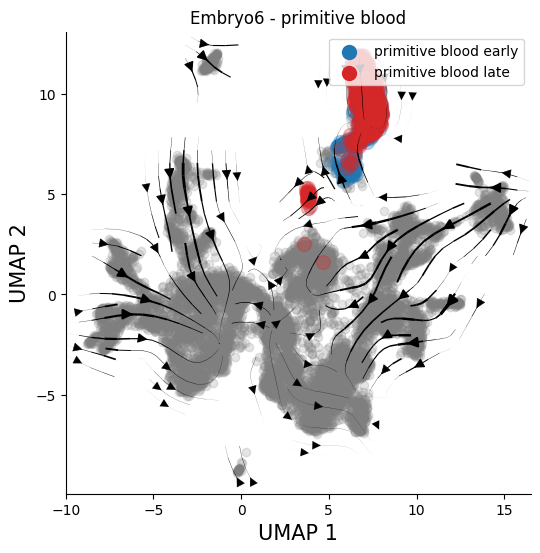

In [33]:
fig, ax = plt.subplots(figsize=(6,6))
all_states = list(set(sd.cell_states))
all_states.sort()
pairs_colors = {'primitive streak ':'tab:red', 
                'primitive blood ':'tab:blue', 
                'neuromesodermal progenitor ':'tab:green', 
                'visceral endoderm ':'tab:orange', 
                'amnion mesoderm ':'tab:purple'}

for i in all_states:
    if cell_state_map[i].replace('early', '').replace('late', '') == 'primitive blood ':
        if 'early' in cell_state_map[i]:
            ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:blue', label=cell_state_map[i], s=100, alpha=0.3, zorder=2)
        else:
            ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:red', label=cell_state_map[i], s=100, alpha=0.3, zorder=3)
    else:
        ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:grey',alpha=0.2, zorder=0)

pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=1, lw_coef=10000, arrowsize=1.5)

lgnd = ax.legend(loc='upper right', fontsize=10)
lgnd.legendHandles[0]._alpha = [1]
lgnd.legendHandles[1]._alpha = [1]
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Embryo6 - primitive blood')
# plt.savefig('./figures/embryos/embryo6_primitive_blood.pdf', dpi='figure', format='pdf')

Text(0.5, 1.0, 'Embryo6 - amnion mesoderm')

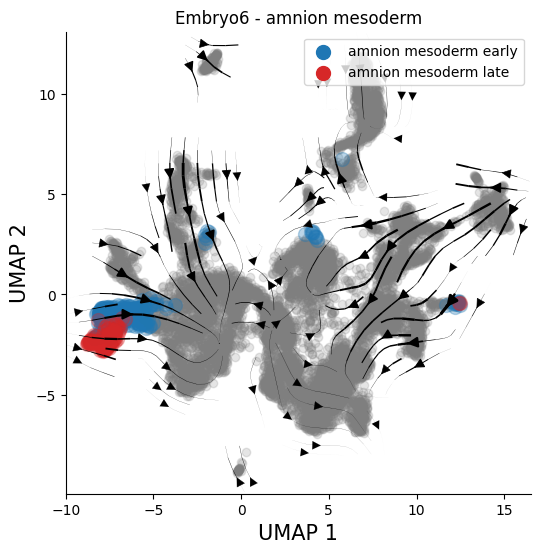

In [22]:
fig, ax = plt.subplots(figsize=(6,6))
all_states = list(set(sd.cell_states))
all_states.sort()
pairs_colors = {'primitive streak ':'tab:red', 
                'primitive blood ':'tab:blue', 
                'neuromesodermal progenitor ':'tab:green', 
                'visceral endoderm ':'tab:orange', 
                'amnion mesoderm ':'tab:purple'}

for i in all_states:
    if cell_state_map[i].replace('early', '').replace('late', '') == 'amnion mesoderm ':
        if 'early' in cell_state_map[i]:
            ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:blue', label=cell_state_map[i], s=100, alpha=0.3, zorder=2)
        else:
            ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:red', label=cell_state_map[i], s=100, alpha=0.3, zorder=3)
    else:
        ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:grey',alpha=0.2, zorder=0)

pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=1, lw_coef=10000, arrowsize=1.5)

lgnd = ax.legend(loc='upper right', fontsize=10)
lgnd.legendHandles[0]._alpha = [1]
lgnd.legendHandles[1]._alpha = [1]
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Embryo6 - amnion mesoderm')
# plt.savefig('./figures/embryos/embryo6_primitive_blood.pdf', dpi='figure', format='pdf')

Text(0.5, 1.0, 'Embryo6 - visceral endoderm ')

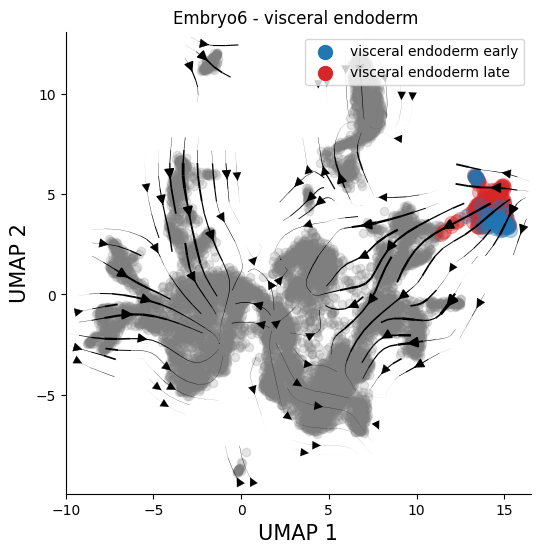

In [86]:
fig, ax = plt.subplots(figsize=(6,6))
all_states = list(set(sd.cell_states))
all_states.sort()
pairs_colors = {'primitive streak ':'tab:red', 
                'primitive blood ':'tab:blue', 
                'neuromesodermal progenitor ':'tab:green', 
                'visceral endoderm ':'tab:orange', 
                'amnion mesoderm ':'tab:purple'}

for i in all_states:
    if cell_state_map[i].replace('early', '').replace('late', '') == 'visceral endoderm ':
        if 'early' in cell_state_map[i]:
            ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:blue', label=cell_state_map[i], s=100, alpha=0.3, zorder=3)
        else:
            ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:red', label=cell_state_map[i], s=100, alpha=0.3, zorder=2)
    else:
        ax.scatter(sd.Xdr.loc[sd.cell_states==i].iloc[:,0], sd.Xdr.loc[sd.cell_states==i].iloc[:,1], c='tab:grey',alpha=0.2, zorder=0)

pv.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=1, lw_coef=10000, arrowsize=1.5)

lgnd = ax.legend(loc='upper right', fontsize=10)
lgnd.legendHandles[0]._alpha = [1]
lgnd.legendHandles[1]._alpha = [1]
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Embryo6 - visceral endoderm ')
# plt.savefig('./figures/embryos/embryo6_primitive_blood.pdf', dpi='figure', format='pdf')

In [97]:
pv.calc_phylo_pseudotime(sd, n_neighbors=100, r_sample=0.06)

  0%|          | 0/612 [00:00<?, ?it/s]

In [132]:
plt.rcParams['font.size']=12

Text(0.5, 1.0, 'Embryo6')

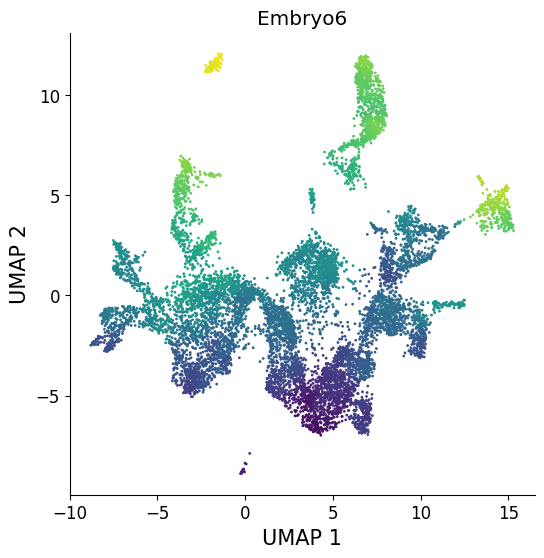

In [135]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(sd.Xdr.iloc[:,0], sd.Xdr.iloc[:,1], c=sd.phylo_pseudotime, s=1)

# ax.set_xlim((-7, 16))
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title('Embryo6')

In [40]:
v_megs = pd.DataFrame(data=sd.velocity, index=sd.x_normed.columns, columns=['velocity']).loc[sd.megs]
v_megs['p_value']=sd.pvals.T
v_megs['q_value']=sd.qvals.T
v_megs.to_csv('./megs/embryo6_all_mutnum.csv')

In [45]:
from copy import deepcopy
sd_shuffle = deepcopy(sd)
np.random.shuffle(mutnum)
pv.velocity_inference(sd_shuffle, mutnum, cutoff=0.97, target='x_normed')
v_megs = pd.DataFrame(data=sd_shuffle.velocity, index=sd_shuffle.x_normed.columns, columns=['velocity']).loc[sd_shuffle.megs]
v_megs['p_value']=sd_shuffle.pvals.T
v_megs['q_value']=sd_shuffle.qvals.T
v_megs.to_csv('./megs/embryo6_all_shuffle.csv')

  0%|          | 0/14146 [00:00<?, ?it/s]